# 2 - Workflow management with atomate

In this lesson we cover a few more advanced features of the atomate software package.  More specifically we'll go over an example that includes parents and children, talk more about where you can find preset workflows, and cover a basic example of analyzing workflow-generated materials data.

In [1]:
from mp_workshop.atomate import wf_to_graph, use_fake_vasp_workshop
from tqdm import tqdm_notebook


Echo Test: MP Workshop


## Why use atomate?

Just to motivate this lesson a bit more, I'd like to share an example that illustrates the value of atomate.  Let's say you wanted to calculate the bandstructure of every polymorph of SiO$_2$.  Normally, you'd need to get all of the cifs from MP or the ICSD, construct the POSCARs by hand, or use some of your own infrastructure to convert them, run the calculations and manage the directory structure, and aggregate the results in a way that allowed you to analyze them together.  In atomate, this is achieved in a simple, five line snippet:

In [2]:
from atomate.vasp.workflows.presets.core import get_wf
from fireworks import LaunchPad

lpad = LaunchPad.auto_load()
lpad.reset("", require_password=False)

from pymatgen import MPRester
mpr = MPRester('')

structures = mpr.get_structures("SiO2")
for structure in tqdm_notebook(structures):
    wf = get_wf(structure, "bandstructure.yaml")
    lpad.add_wf(wf)

2019-07-25 17:54:55,025 INFO Performing db tune-up
2019-07-25 17:54:55,563 INFO LaunchPad was RESET.


2019-07-25 17:55:00,513 INFO Added a workflow. id_map: {-4: 1, -3: 2, -2: 3, -1: 4}
2019-07-25 17:55:00,669 INFO Added a workflow. id_map: {-8: 5, -7: 6, -6: 7, -5: 8}
2019-07-25 17:55:00,821 INFO Added a workflow. id_map: {-12: 9, -11: 10, -10: 11, -9: 12}
2019-07-25 17:55:00,873 INFO Added a workflow. id_map: {-16: 13, -15: 14, -14: 15, -13: 16}
2019-07-25 17:55:00,971 INFO Added a workflow. id_map: {-20: 17, -19: 18, -18: 19, -17: 20}
2019-07-25 17:55:01,046 INFO Added a workflow. id_map: {-24: 21, -23: 22, -22: 23, -21: 24}
2019-07-25 17:55:01,078 INFO Added a workflow. id_map: {-28: 25, -27: 26, -26: 27, -25: 28}
2019-07-25 17:55:01,196 INFO Added a workflow. id_map: {-32: 29, -31: 30, -30: 31, -29: 32}
2019-07-25 17:55:01,252 INFO Added a workflow. id_map: {-36: 33, -35: 34, -34: 35, -33: 36}
2019-07-25 17:55:01,419 INFO Added a workflow. id_map: {-40: 37, -39: 38, -38: 39, -37: 40}
2019-07-25 17:55:01,467 INFO Added a workflow. id_map: {-44: 41, -43: 42, -42: 43, -41: 44}
2019-0

2019-07-25 17:55:10,539 INFO Added a workflow. id_map: {-344: 341, -343: 342, -342: 343, -341: 344}
2019-07-25 17:55:10,731 INFO Added a workflow. id_map: {-348: 345, -347: 346, -346: 347, -345: 348}
2019-07-25 17:55:10,894 INFO Added a workflow. id_map: {-352: 349, -351: 350, -350: 351, -349: 352}
2019-07-25 17:55:11,061 INFO Added a workflow. id_map: {-356: 353, -355: 354, -354: 355, -353: 356}
2019-07-25 17:55:11,229 INFO Added a workflow. id_map: {-360: 357, -359: 358, -358: 359, -357: 360}
2019-07-25 17:55:11,634 INFO Added a workflow. id_map: {-364: 361, -363: 362, -362: 363, -361: 364}
2019-07-25 17:55:11,891 INFO Added a workflow. id_map: {-368: 365, -367: 366, -366: 367, -365: 368}
2019-07-25 17:55:11,995 INFO Added a workflow. id_map: {-372: 369, -371: 370, -370: 371, -369: 372}
2019-07-25 17:55:12,363 INFO Added a workflow. id_map: {-376: 373, -375: 374, -374: 375, -373: 376}
2019-07-25 17:55:12,706 INFO Added a workflow. id_map: {-380: 377, -379: 378, -378: 379, -377: 380}


2019-07-25 17:55:20,235 INFO Added a workflow. id_map: {-672: 669, -671: 670, -670: 671, -669: 672}
2019-07-25 17:55:20,262 INFO Added a workflow. id_map: {-676: 673, -675: 674, -674: 675, -673: 676}
2019-07-25 17:55:20,321 INFO Added a workflow. id_map: {-680: 677, -679: 678, -678: 679, -677: 680}
2019-07-25 17:55:20,376 INFO Added a workflow. id_map: {-684: 681, -683: 682, -682: 683, -681: 684}
2019-07-25 17:55:20,477 INFO Added a workflow. id_map: {-688: 685, -687: 686, -686: 687, -685: 688}
2019-07-25 17:55:20,569 INFO Added a workflow. id_map: {-692: 689, -691: 690, -690: 691, -689: 692}
2019-07-25 17:55:20,757 INFO Added a workflow. id_map: {-696: 693, -695: 694, -694: 695, -693: 696}
2019-07-25 17:55:20,857 INFO Added a workflow. id_map: {-700: 697, -699: 698, -698: 699, -697: 700}
2019-07-25 17:55:20,956 INFO Added a workflow. id_map: {-704: 701, -703: 702, -702: 703, -701: 704}
2019-07-25 17:55:21,088 INFO Added a workflow. id_map: {-708: 705, -707: 706, -706: 707, -705: 708}


2019-07-25 17:55:29,236 INFO Added a workflow. id_map: {-1000: 997, -999: 998, -998: 999, -997: 1000}
2019-07-25 17:55:29,309 INFO Added a workflow. id_map: {-1004: 1001, -1003: 1002, -1002: 1003, -1001: 1004}
2019-07-25 17:55:29,333 INFO Added a workflow. id_map: {-1008: 1005, -1007: 1006, -1006: 1007, -1005: 1008}
2019-07-25 17:55:29,380 INFO Added a workflow. id_map: {-1012: 1009, -1011: 1010, -1010: 1011, -1009: 1012}
2019-07-25 17:55:29,430 INFO Added a workflow. id_map: {-1016: 1013, -1015: 1014, -1014: 1015, -1013: 1016}
2019-07-25 17:55:29,536 INFO Added a workflow. id_map: {-1020: 1017, -1019: 1018, -1018: 1019, -1017: 1020}
2019-07-25 17:55:29,726 INFO Added a workflow. id_map: {-1024: 1021, -1023: 1022, -1022: 1023, -1021: 1024}
2019-07-25 17:55:29,898 INFO Added a workflow. id_map: {-1028: 1025, -1027: 1026, -1026: 1027, -1025: 1028}
2019-07-25 17:55:30,000 INFO Added a workflow. id_map: {-1032: 1029, -1031: 1030, -1030: 1031, -1029: 1032}
2019-07-25 17:55:30,059 INFO Added

This snippet attests to the so-called "high-throughput" approach, which has value both because it enables you to aggregate a lot of data quickly in a way that is only possible in computational materials science and because it enables you to examine trends in a large dataset much more quickly, which is typically the most valuable way to use DFT-based simulation.

Before we move on, let's reset the workflow database.

In [3]:
lpad.reset(password="", require_password=False, max_reset_wo_password=10000)

2019-07-25 17:55:45,561 INFO Performing db tune-up
2019-07-25 17:55:45,706 INFO LaunchPad was RESET.


## The elastic tensor: A multi-step preset workflow

In addition to enabling "high-throughput" functionality, atomate allows you to execute a relatively complex set of instructions using very simple constructions.  Our canonical example of this functionality is contained in the elastic workflow.

In [4]:
structure = mpr.get_structure_by_material_id(
    "mp-149", conventional_unit_cell=True)
structure

Structure Summary
Lattice
    abc : 5.468727957193058 5.468727957193058 5.468727957193058
 angles : 90.0 90.0 90.0
 volume : 163.55316755397953
      A : 5.468727957193058 0.0 3.348630094092061e-16
      B : 8.794385292882e-16 5.468727957193058 3.348630094092061e-16
      C : 0.0 0.0 5.468727957193058
PeriodicSite: Si (1.3672, 1.3672, 1.3672) [0.2500, 0.2500, 0.2500]
PeriodicSite: Si (2.7344, 2.7344, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Si (1.3672, 4.1015, 4.1015) [0.2500, 0.7500, 0.7500]
PeriodicSite: Si (2.7344, 0.0000, 2.7344) [0.5000, 0.0000, 0.5000]
PeriodicSite: Si (4.1015, 1.3672, 4.1015) [0.7500, 0.2500, 0.7500]
PeriodicSite: Si (0.0000, 2.7344, 2.7344) [0.0000, 0.5000, 0.5000]
PeriodicSite: Si (4.1015, 4.1015, 1.3672) [0.7500, 0.7500, 0.2500]
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

In [5]:
from mp_workshop import view

In [6]:
view(structure)

/srv/conda/envs/notebook/lib/python3.7/site-packages/crystal_toolkit/core/mpcomponent.py:64: UserWarning:

No app defined for component StructureMoleculeComponent, callbacks cannot be created. Please register app using MPComponent.register_app(app).

/srv/conda/envs/notebook/lib/python3.7/site-packages/crystal_toolkit/core/mpcomponent.py:71: UserWarning:

No cache is defined for component StructureMoleculeComponent, performance of app may be degraded. Please register cache using MPComponent.register_cache(cache).

/srv/conda/envs/notebook/lib/python3.7/site-packages/pymatgen/analysis/local_env.py:3549: UserWarning:

CrystalNN: distance cutoffs set but no oxidation states specified on sites! For better results, set the site oxidation states in the structure.

/srv/conda/envs/notebook/lib/python3.7/site-packages/pymatgen/analysis/local_env.py:3364: UserWarning:

CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.



Renderer(camera=OrthographicCamera(bottom=-9.472114674630733, far=4000.0, left=-9.472114674630733, near=-4000.…

In [7]:
from atomate.vasp.workflows.presets.core import wf_elastic_constant, wf_elastic_constant_minimal

In [8]:
wf = wf_elastic_constant(structure)

Here's a rendering of the control flow associated with the firework, which you can see both here and in the fireworks dashboard.

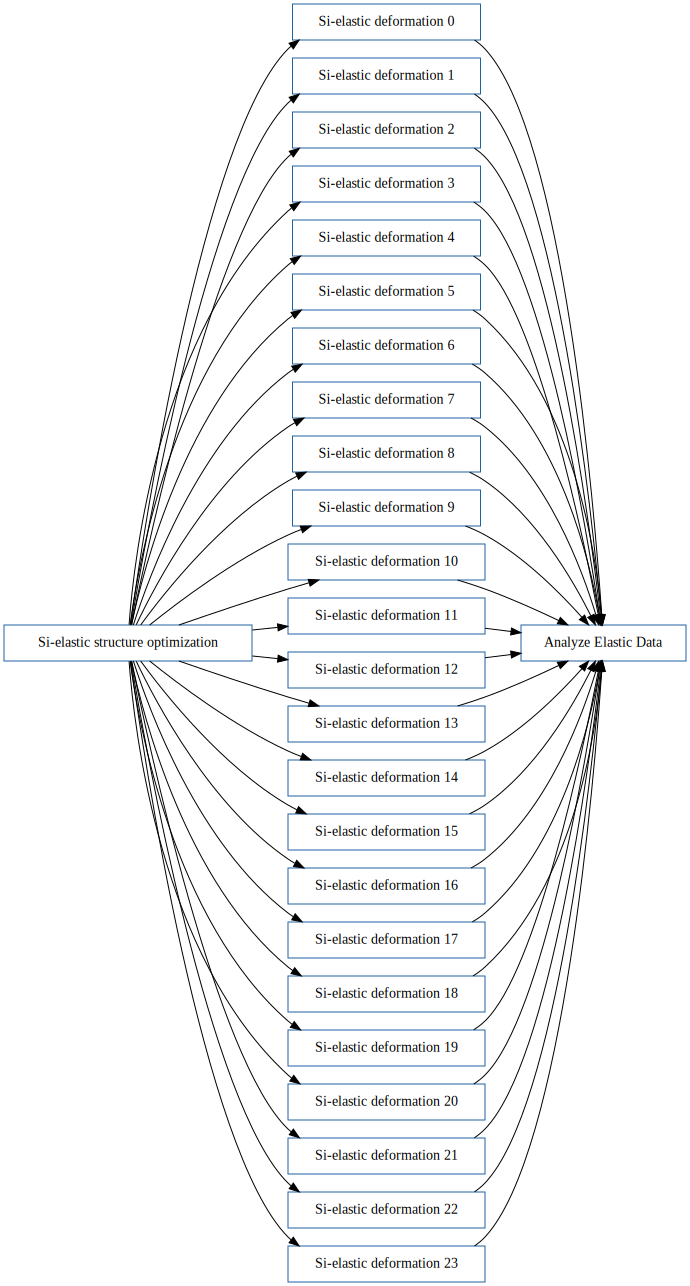

In [9]:
from mp_workshop.atomate import wf_to_graph
wf_to_graph(wf)

From our exploration of the workflow, we can see that the workflow has a "root" firework, which is the structure optimization firework, and a single "leaf" firework, which is the analysis task.  In between, we have several fireworks which have "elastic deformation" in their titles, each of which represents a calculation which will transform the output of the optimization firework by applying a unique strain.

In the analysis step, the stresses from those deformations and the strains are aggregated and used to fit an elastic tensor.  Let's examine the different types of fireworks using the graph tool.

Si-elastic structure optimization


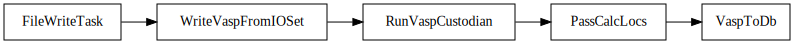

In [10]:
print(wf.fws[0].name)
wf_to_graph(wf.fws[0])

Si-elastic deformation 0


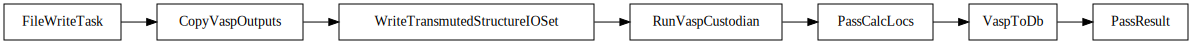

In [11]:
print(wf.fws[1].name)
wf_to_graph(wf.fws[1])

Analyze Elastic Data


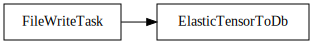

In [12]:
print(wf.fws[-1].name)
wf_to_graph(wf.fws[-1])

Note that the standard preset workflow for the elastic tensor uses many calculations in excess of what is required to determine the elastic tensor, which yields a higher-quality tensor in which some of the numerical noise is washed out over the duplicity of calculations.  Note that you can also generate a "minimal" elastic workflow which uses neither the more expensive DFT parameters nor the extended calculations.  Tensors generated using this workflow are typically not as accurate, but often work for simple semiconductors with a lot of symmetry.  Let's try it with bulk silicon.

In [13]:
wf = wf_elastic_constant_minimal(structure)

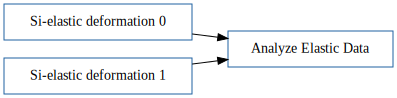

In [14]:
wf_to_graph(wf)

Note that for silicon, the two deformation tasks are a single normal deformation along the x axis (which are equivalent to those along the y- and z-axis), and a single shear deformation (equivalent to the two others normally included).  Since this is considerably simpler, we'll run this as our example.

To run the workflow, we import our launchpad and rocket launcher tools.  Since we can't use VASP in the workflow, we're also going to "fake" vasp by copying files rather than running the binary.

In [15]:
from fireworks import LaunchPad
from mp_workshop.atomate import use_fake_vasp_workshop

In [16]:
wf.name

'Si:elastic constants'

In [17]:
wf = use_fake_vasp_workshop(wf)
lpad.add_wf(wf)

2019-07-25 17:56:18,056 INFO Added a workflow. id_map: {-1213: 1, -1212: 2, -1211: 3}


{-1213: 1, -1212: 2, -1211: 3}

Now we can run the workflow either in the notebook using the pythonic fireworks rocket launcher or using `qlaunch` from the linux command line.

In [18]:
from fireworks.core.rocket_launcher import rapidfire

In [19]:
import os

In [20]:
if not os.path.exists('temp'):
    os.makedirs('temp')
    os.chdir("temp")
rapidfire(lpad)

2019-07-25 17:56:21,925 INFO Created new dir /home/jovyan/lessons/atomate/temp/launcher_2019-07-25-17-56-21-924599
2019-07-25 17:56:21,928 INFO Launching Rocket
2019-07-25 17:56:22,044 INFO RUNNING fw_id: 3 in directory: /home/jovyan/lessons/atomate/temp/launcher_2019-07-25-17-56-21-924599
2019-07-25 17:56:22,138 INFO Task started: FileWriteTask.
2019-07-25 17:56:22,145 INFO Task completed: FileWriteTask 
2019-07-25 17:56:22,155 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2019-07-25 17:56:22,206 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2019-07-25 17:56:22,223 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-25 17:56:22,281 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2019-07-25 17:56:22,366 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-25 17:56:22,375 INFO Task completed: {{atomate.vasp

/srv/conda/envs/notebook/lib/python3.7/site-packages/pymatgen/analysis/elasticity/elastic.py:911: UserWarning:

No eq state found, returning zero voigt stress



2019-07-25 17:56:28,818 INFO atomate.vasp.firetasks.parse_outputs Elastic analysis complete.
2019-07-25 17:56:28,822 INFO Task completed: {{atomate.vasp.firetasks.parse_outputs.ElasticTensorToDb}} 
2019-07-25 17:56:28,988 INFO Rocket finished


## Powerups

Atomate contains a number of tools for modifying workflows, known as "powerups" which are functions which will modify the workflows in commonly desired ways.  For example, if you want to modify the parameters of a VASP calculation, you can use the add_modify_incar powerup to change these for every firework in the workflow.

### add_modify_incar

In [21]:
from atomate.vasp.powerups import add_modify_incar

In [22]:
wf = get_wf(structure, "bandstructure.yaml")

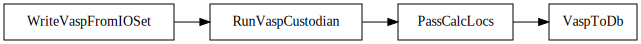

In [23]:
wf_to_graph(wf.fws[0])

In [24]:
modified = add_modify_incar(wf, {"incar_update": {"ENCUT": 700}})

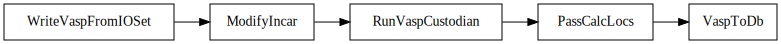

In [25]:
wf_to_graph(modified.fws[0])

Prior to the execution of the VASP calculation, a ModifyIncar firetask is inserted which will read the incar and modify the ENCUT parameter such that it matches our powerup specification.

### add_tags, add_structure_metadata

In [26]:
from atomate.vasp.powerups import add_tags

In [27]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'db_file': '>>db_file<<', 'additional_fields': {'task_label': 'structure optimization'}}


In [28]:
wf = add_tags(wf, ["photocathodes"])

In [29]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {'tags': ['photocathodes']}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'db_file': '>>db_file<<', 'additional_fields': {'task_label': 'structure optimization', 'tags': ['photocathodes']}}


## A few other "complex" workflows.

Atomate contains a few workflows that will do more complicating things like calculations on surfaces.  Let's say I want to calculate the determine the hydrogen adsorption energy on every low-index facet of Pt.

In [30]:
from atomate.vasp.workflows.base.adsorption import get_wfs_all_slabs
from pymatgen import MPRester, Molecule

In [31]:
pt = mpr.get_structure_by_material_id("Pt", conventional_unit_cell=True)
adsorbate = Molecule("H", [[0, 0, 0]])

In [32]:
wf = get_wfs_all_slabs(pt, adsorbates = [adsorbate])

/srv/conda/envs/notebook/lib/python3.7/site-packages/pymatgen/core/structure.py:638: UserWarning:

Not all sites have property bulk_wyckoff. Missing values are set to None.

/srv/conda/envs/notebook/lib/python3.7/site-packages/pymatgen/core/structure.py:638: UserWarning:

Not all sites have property bulk_equivalent. Missing values are set to None.



'WF 0 ============================='

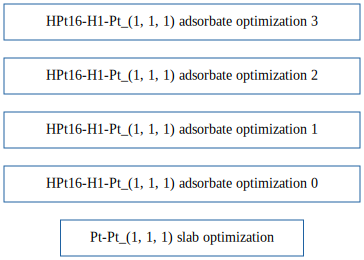

'WF 1 ============================='

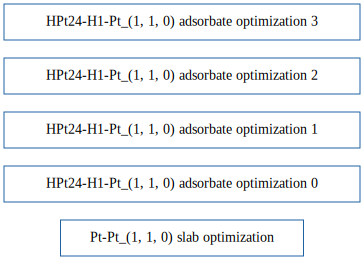

'WF 2 ============================='

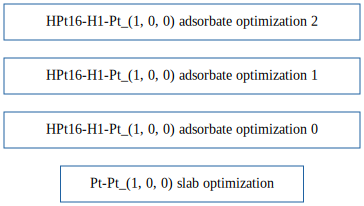

In [33]:
from IPython.display import display
display("WF 0 =============================")
display(wf_to_graph(wf[0]))
display("WF 1 =============================")
display(wf_to_graph(wf[1]))
display("WF 2 =============================")
display(wf_to_graph(wf[2]))

This is how you can do the requisite calculation to find the band-gap from an HSE calculation after the PBE bandstructure.

In [34]:
from atomate.vasp.workflows.presets.core import wf_bandstructure_plus_hse

In [35]:
wf = wf_bandstructure_plus_hse(structure)

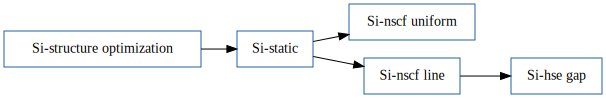

In [36]:
wf_to_graph(wf)

There's also support for workflows in FEFF and QChem.

In [37]:
from atomate.feff.workflows.core import get_wf_xas

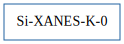

In [38]:
wf = get_wf_xas("Si", structure)
wf_to_graph(wf)

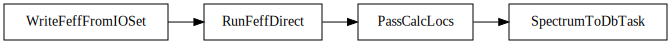

In [39]:
wf_to_graph(wf.fws[0])

In [40]:
#from atomate.qchem.workflows.base.double_FF_opt import get_wf_double_FF_opt
#from pymatgen import Molecule
#molecule = Molecule("CO", [[0, 0, 0], [0, 0, 1.23]])
#wf = get_wf_double_FF_opt(molecule, 0.5)
#wf_to_graph(wf)
#wf_to_graph(wf.fws[0])

## Analyzing workflow results

Our final example for atomate will take a set of tasks from our database and construct a phase diagram.

To do this, we will first submit a series of structure optimizations using the `get_wf_from_spec_dict` utility which allows us to reuse the same calculation settings.

This is essentially like the `bandstructure.yaml` file we used for the band structure calculations earlier.
```
# A typical band structure
# Author: Anubhav Jain (ajain@lbl.gov)
fireworks:
- fw: atomate.vasp.fireworks.core.OptimizeFW
- fw: atomate.vasp.fireworks.core.StaticFW
  params:
    parents: 0
- fw: atomate.vasp.fireworks.core.NonSCFFW
  params:
    parents: 1
    mode: uniform
- fw: atomate.vasp.fireworks.core.NonSCFFW
  params:
    parents: 1
    mode: line
```


In [41]:
import json
from monty.serialization import loadfn
from atomate.utils.utils import get_wf_from_spec_dict

def get_custom_wf(struct, cal_yaml, add_tags={}):
    """
    Create a a customized atomate workflow from a yaml file
    """
    d = loadfn(cal_yaml)
    wf = get_wf_from_spec_dict(struct, d)
    return wf

Assuming we want to override a basic VASP flag

In [42]:
%%file opti.yaml  
fireworks:
# Relaxation for
- fw: atomate.vasp.fireworks.core.OptimizeFW
  override_default_vasp_params:
    user_incar_settings:
        ISPIN: 2


Writing opti.yaml


We can run this workflow on for materials in teh Al-Cr system

In [43]:
# get the structures in the Al-Cr system
# create workflows using those structures
# remember to modify the workflows using use_fake_vasp_workshop 

structures = mpr.get_structures("Al-Cr")
structures += mpr.get_structures("Al")
structures += mpr.get_structures("Cr")
for structure in structures:
    wf = get_custom_wf(structure, 'opti.yaml')
    wf = use_fake_vasp_workshop(wf)
    lpad.add_wf(wf)


2019-07-25 17:57:22,306 INFO Added a workflow. id_map: {-1238: 4}
2019-07-25 17:57:22,340 INFO Added a workflow. id_map: {-1239: 5}
2019-07-25 17:57:22,403 INFO Added a workflow. id_map: {-1240: 6}
2019-07-25 17:57:22,415 INFO Added a workflow. id_map: {-1241: 7}
2019-07-25 17:57:22,429 INFO Added a workflow. id_map: {-1242: 8}
2019-07-25 17:57:22,446 INFO Added a workflow. id_map: {-1243: 9}
2019-07-25 17:57:22,464 INFO Added a workflow. id_map: {-1244: 10}
2019-07-25 17:57:22,486 INFO Added a workflow. id_map: {-1245: 11}
2019-07-25 17:57:22,503 INFO Added a workflow. id_map: {-1246: 12}
2019-07-25 17:57:22,521 INFO Added a workflow. id_map: {-1247: 13}
2019-07-25 17:57:22,556 INFO Added a workflow. id_map: {-1248: 14}
2019-07-25 17:57:22,584 INFO Added a workflow. id_map: {-1249: 15}


In [44]:
from fireworks.core.rocket_launcher import rapidfire
from mp_workshop.atomate import use_fake_vasp_workshop
import os
if not os.path.exists('temp'):
    os.makedirs('temp')
os.chdir("temp")
rapidfire(lpad)    
os.chdir("..")


2019-07-25 17:57:24,914 INFO Created new dir /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-24-914159
2019-07-25 17:57:24,916 INFO Launching Rocket
2019-07-25 17:57:25,000 INFO RUNNING fw_id: 4 in directory: /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-24-914159
2019-07-25 17:57:25,030 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-25 17:57:25,054 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-25 17:57:25,084 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-25 17:57:25,174 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully


/srv/conda/envs/notebook/lib/python3.7/site-packages/pymatgen/io/vasp/sets.py:417: BadInputSetWarning:

Relaxation of likely metal with ISMEAR < 1 detected. Please see VASP recommendations on ISMEAR for metals.



2019-07-25 17:57:25,359 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-25 17:57:25,380 INFO Task completed: {{atomate.vasp.firetasks.run_calc.RunVaspFake}} 
2019-07-25 17:57:25,414 INFO Task started: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}}.
2019-07-25 17:57:25,418 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}} 
2019-07-25 17:57:25,438 INFO Task started: {{atomate.vasp.firetasks.parse_outputs.VaspToDb}}.
2019-07-25 17:57:25,440 INFO atomate.vasp.firetasks.parse_outputs PARSING DIRECTORY: /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-24-914159
2019-07-25 17:57:25,452 INFO atomate.vasp.drones Getting task doc for base dir :/home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-24-914159
2019-07-25 17:57:29,408 INFO atomate.vasp.drones Post-processing dir:/home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-24-914159
2019-07-25 17:57:29,414 WARNING atomate.vasp.drone

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/run_calc.py", line 276, in run_task
    self._verify_inputs()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/atomate/vasp/firetasks/run_calc.py", line 287, in _verify_inputs
    ref_incar = Incar.from_file(os.path.join(self["ref_dir"], "inputs", "INCAR"))
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/pymatgen/io/vasp/inputs.py", line 726, in from_file
    with zopen(filename, "rt") as f:
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/monty/io.py", line 72, in zopen
    return io.open(filename, *args, **kwargs)
FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/mp_workshop/fake_vasp/Al_Cr/Al45Cr7_7.10/inputs/INCAR'


2019-07-25 17:57:36,192 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}} 
2019-07-25 17:57:36,203 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2019-07-25 17:57:36,287 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2019-07-25 17:57:36,408 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2019-07-25 17:57:36,411 INFO Task completed: {{atomate.vasp.firetasks.run_calc.RunVaspFake}} 
2019-07-25 17:57:36,428 INFO Task started: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}}.
2019-07-25 17:57:36,431 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}} 
2019-07-25 17:57:36,441 INFO Task started: {{atomate.vasp.firetasks.parse_outputs.VaspToDb}}.
2019-07-25 17:57:36,444 INFO atomate.vasp.firetasks.parse_outputs PARSING DIRECTORY: /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-36-066731
2019-07-25 17:57:36,457 INFO atomate.vasp.drones 

2019-07-25 17:57:44,016 INFO atomate.vasp.drones Post-processed /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-42-346323
2019-07-25 17:57:44,080 INFO atomate.utils.database Inserting 6cdeae31b639:/home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-42-346323 with taskid = 8
2019-07-25 17:57:44,125 INFO atomate.vasp.firetasks.parse_outputs Finished parsing with task_id: 8
2019-07-25 17:57:44,156 INFO Task completed: {{atomate.vasp.firetasks.parse_outputs.VaspToDb}} 
2019-07-25 17:57:44,237 INFO Rocket finished
2019-07-25 17:57:44,256 INFO Created new dir /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-44-256410
2019-07-25 17:57:44,262 INFO Launching Rocket
2019-07-25 17:57:44,353 INFO RUNNING fw_id: 11 in directory: /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-44-256410
2019-07-25 17:57:44,378 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteVaspFromIOSet}}.
2019-07-25 17:57:44,396 INFO Task completed: {{ato

2019-07-25 17:57:51,377 INFO Task completed: {{atomate.vasp.firetasks.run_calc.RunVaspFake}} 
2019-07-25 17:57:51,396 INFO Task started: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}}.
2019-07-25 17:57:51,399 INFO Task completed: {{atomate.common.firetasks.glue_tasks.PassCalcLocs}} 
2019-07-25 17:57:51,407 INFO Task started: {{atomate.vasp.firetasks.parse_outputs.VaspToDb}}.
2019-07-25 17:57:51,408 INFO atomate.vasp.firetasks.parse_outputs PARSING DIRECTORY: /home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-51-044122
2019-07-25 17:57:51,412 INFO atomate.vasp.drones Getting task doc for base dir :/home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-51-044122
2019-07-25 17:57:52,683 INFO atomate.vasp.drones Post-processing dir:/home/jovyan/lessons/atomate/temp/temp/launcher_2019-07-25-17-57-51-044122
2019-07-25 17:57:52,691 WARNING atomate.vasp.drones Transformations file does not exist.
2019-07-25 17:57:52,736 INFO atomate.vasp.drones Post-processed /hom

## The calculations have finished

When atomates runs a Quantum Chemistry calculation, the output is stored in a collection defined by the db.json file.

IMPORTANT: The location of this file will be different depending on how you setup your system, and this db.json file must be access on the computing cluster where your simulation are running.


In [46]:
!cat /home/jovyan/mp_workshop/fireworks_config/db.json

{
    "aliases": {}, 
    "collection": "tasks",
    "database": "mp_workshop",
    "host": "localhost", 
    "port": 27017
}


The data from our fake vasp calculations are used to populate the `tasks` collection on `localhost:mp_workshop`. 

To access these results we can use `pymongo` or our wrapper for `pymongo` --- (`maggma`) 

In [47]:
# We can look at these results by querying database
from maggma.stores import MongoStore
tasks = MongoStore(database="mp_workshop", collection_name="tasks")
tasks.connect()
tasks.query_one()

{'_id': ObjectId('5d39ed485acc9fdf35f07456'),
 'dir_name': '6cdeae31b639:/home/jovyan/lessons/atomate/temp/launcher_2019-07-25-17-56-21-924599',
 'analysis': {'delta_volume': 0.0,
  'delta_volume_as_percent': 0.0,
  'max_force': 0.0,
  'warnings': [],
  'errors': []},
 'calcs_reversed': [{'vasp_version': '5.4.4',
   'has_vasp_completed': True,
   'nsites': 8,
   'elements': ['Si'],
   'nelements': 1,
   'run_type': 'None or LDA',
   'input': {'incar': {'ISTART': 1,
     'PREC': 'high',
     'ALGO': 'Normal',
     'ISPIN': 2,
     'ICHARG': 0,
     'NELM': 100,
     'IBRION': 2,
     'EDIFF': 0.0004,
     'NSW': 99,
     'ISIF': 2,
     'ENCUT': 520.0,
     'MAGMOM': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
     'LREAL': 'Auto',
     'ISMEAR': -5,
     'SIGMA': 0.05,
     'LWAVE': False,
     'LCHARG': True,
     'LVHAR': True,
     'LORBIT': 11,
     'LAECHG': True,
     'KPOINT_BSE': [-1, 0, 0, 0]},
    'kpoints': {'comment': 'Kpoints from vasprun.xml',
     'nkpoints': 0,
     'gene

In [48]:
tasks = MongoStore(database="mp_workshop", collection_name="tasks")

In [49]:
tasks.connect()

In [50]:
doc = tasks.query_one()

In [51]:
doc.keys()

dict_keys(['_id', 'dir_name', 'analysis', 'calcs_reversed', 'chemsys', 'completed_at', 'composition_reduced', 'composition_unit_cell', 'custodian', 'elements', 'formula_anonymous', 'formula_pretty', 'formula_reduced_abc', 'input', 'last_updated', 'nelements', 'nsites', 'orig_inputs', 'output', 'run_stats', 'schema', 'state', 'task_id', 'task_label', 'transformations', 'transmuter'])

In [52]:
doc['chemsys']

'Si'

In [53]:
doc = tasks.query_one(criteria={"chemsys": "Al"}, properties=['output'])

In [54]:
docs = tasks.query(criteria={"chemsys": "Al-Cr", 
                             "task_label": "structure optimization"},
                   properties=['output', 'formula_pretty'])
docs

In [55]:
docs = list(docs)

In [56]:
[d['formula_pretty'] for d in docs]

['AlCr2', 'Al8Cr5', 'Al3Cr']

In [57]:
fe_cr_tasks = []
for chemsys in ['Al', 'Cr', 'Al-Cr']:
    task_list = tasks.query(criteria={"chemsys": chemsys,
                                      "task_label": "structure optimization"},
                            properties=["output", "composition_unit_cell"])
    fe_cr_tasks.extend(list(task_list))

In [58]:
len(fe_cr_tasks)

11

In [59]:
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen import Composition

In [60]:
entries = []
for task in fe_cr_tasks:
    energy = task['output']['energy']
    composition = Composition.from_dict(task['composition_unit_cell'])
    entry = ComputedEntry(composition, energy)
    entries.append(entry)

In [61]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

In [62]:
pd = PhaseDiagram(entries)

In [63]:
plotter = PDPlotter(pd)

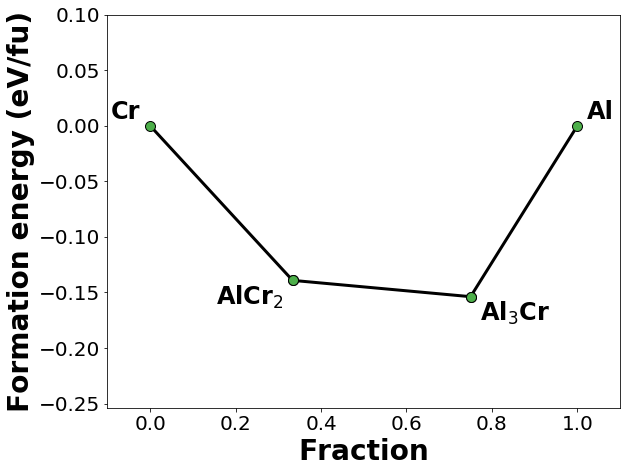

In [64]:
plotter.show()

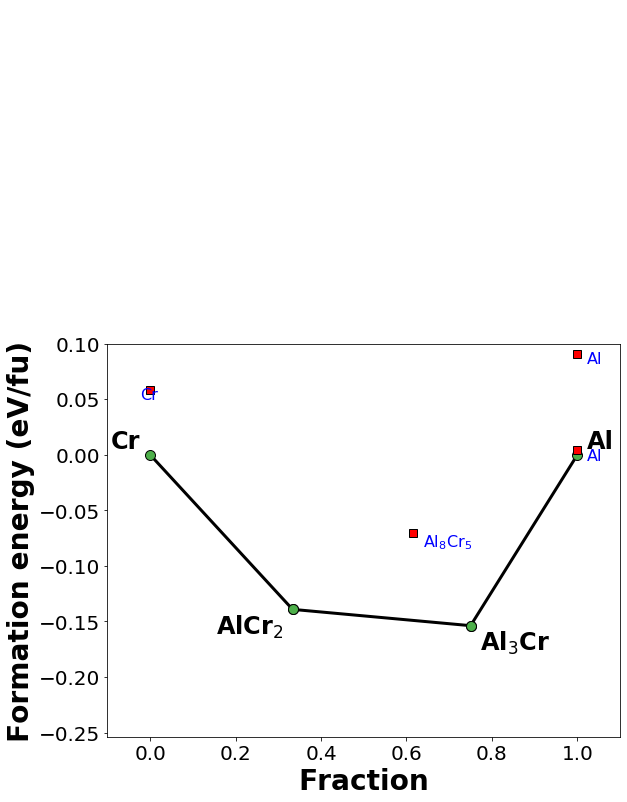

In [65]:
plotter.show_unstable = True
plotter.show()